> This notebook's training doesn't have validation data.
> So this accuracy is not true

In [47]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
from datetime import datetime

In [33]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("Use GPU:", torch.cuda.get_device_name(device))
else:
    device = torch.device('cpu')
    print("Use CPU")

Use GPU: NVIDIA GeForce RTX 3060


In [2]:
# load train data

transform = transforms.Compose([transforms.ToTensor(), ])
train = CIFAR10("./data", train=True,  transform=transform, download=True)
test  = CIFAR10("./data", train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# first, we should find mean & std in 3 channels
# becouse we need use transforms.Normalize() to normalize features

# get pictures's tensor
pics = []
for i in train:
    pics.append(i[0].unsqueeze(0))
print( len(pics) )

50000


In [4]:
pics = torch.cat(pics, dim=0)
print(pics.shape)

torch.Size([50000, 3, 32, 32])


In [5]:
testPics = pics.view(50000, 3, -1)
print( testPics.shape )

# count mean & std
feature_mean = ( testPics.mean(2).sum(0)/50000 ).tolist()
feature_std = (  testPics.std(2).sum(0)/50000 ).tolist()

print("We get mean: {}\nWe get std: {}".format(feature_mean, feature_std))

# On the internet, many people suggest to use ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) to normalization

torch.Size([50000, 3, 1024])
We get mean: [0.4913996756076813, 0.48215845227241516, 0.44653093814849854]
We get std: [0.20230092108249664, 0.19941280782222748, 0.2009616196155548]


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


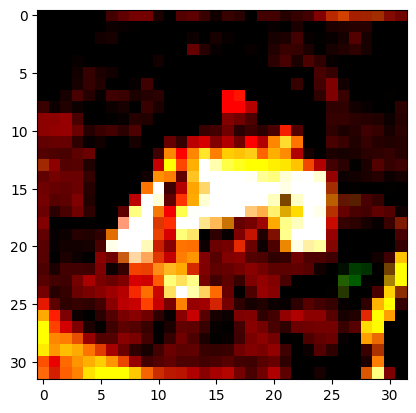

In [6]:
# actual data

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(feature_mean, feature_std)])
train = CIFAR10("./data", train=True,  transform=transform, download=True)

# show 1 picture, it's a frog.
feature, label = train[0]

feature = feature.permute(1, 2, 0)
plt.imshow(feature)
plt.show()

In [72]:
BATCH_SIZE = 128

class CIFAR10_ClassificationModel(nn.Module):
    def __init__(self):
        super(CIFAR10_ClassificationModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=0)
#         self.conv4 = nn.Conv2d(256, 256, 3, stride=1, padding=0)

        self.conv5 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, stride=1, padding=0)

        self.pool  = nn.AvgPool2d(2,stride=2)
        
        self.fc1 = nn.Linear(9216, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        batch = x.shape[0]
        x = self.relu( self.conv1(x) )
        x = self.relu( self.conv2(x) )
        x = self.relu( self.conv3(x) )

        x = self.pool(x)
        x = self.relu( self.conv5(x) )
        x = self.relu( self.conv6(x) )
        x = self.pool(x)
        x = x.view(batch, -1)
        x = self.relu( self.fc1(x) )
        x = self.relu( self.fc2(x) )
        x = self.fc3(x)
        return x

model = CIFAR10_ClassificationModel()
summary(model, input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CIFAR10_ClassificationModel              [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,792
├─ReLU: 1-2                              [128, 64, 32, 32]         --
├─Conv2d: 1-3                            [128, 128, 30, 30]        73,856
├─ReLU: 1-4                              [128, 128, 30, 30]        --
├─Conv2d: 1-5                            [128, 256, 28, 28]        295,168
├─ReLU: 1-6                              [128, 256, 28, 28]        --
├─AvgPool2d: 1-7                         [128, 256, 14, 14]        --
├─Conv2d: 1-8                            [128, 256, 14, 14]        590,080
├─ReLU: 1-9                              [128, 256, 14, 14]        --
├─Conv2d: 1-10                           [128, 256, 12, 12]        590,080
├─ReLU: 1-11                             [128, 256, 12, 12]        --
├─AvgPool2d: 1-12                        [128, 256, 6, 6]      

In [74]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
model = CIFAR10_ClassificationModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    loss_sum = 0
    corr_sum = 0
    for x, y in loader:
        features, labels = x.to(device), y.to(device)

        # clear gradient in optimizer
        optimizer.zero_grad()

        # predict
        predicts = model(features)

        # get loss
        loss = criterion(predicts, labels)
        loss.backward()
        
        # back propagation
        optimizer.step()
        
        # loss & acc
        predicts = torch.argmax(predicts, 1)
        loss_sum += loss.item()
        corr_sum += (predicts==labels).sum()
    print("Epoch {}: {}, {}%".format(epoch, loss_sum/len(loader), corr_sum/len(train)*100))

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)


Current Time = 00:57:57
Epoch 0: 1.5633342016078626, 42.9739990234375%
Epoch 1: 1.030615347120768, 63.2859992980957%
Epoch 2: 0.7714244136420052, 72.7699966430664%
Epoch 3: 0.6027741941344708, 78.95999908447266%
Epoch 4: 0.45929622848320495, 84.03199768066406%
Current Time = 00:59:48
